In [1]:
import numpy as np
from matplotlib import cm
import matplotlib.pyplot as pl
from matplotlib import rcParams
from matplotlib import rc
import pandas
from time import time

# THIS LAST BIT IS TO NAVIAGATE TO WHERE MY CUSTOM MODULES ARE LOCATED
import os
if os.getcwd()[-4:] != 'AIMS':
    default_path = os.getcwd()[:-10]
    os.chdir(default_path)
import aims_loader as aimsLoad
import aims_analysis as aims

# Here is the Notebook Version of the AIMS GUI
Mostly identical to what is going on inside the app, but you have a little bit more flexibility for customization. 

In [2]:
num_loop=6
label = ['poly','mono']

seq1 = aimsLoad.Ig_loader('app/ab_testData/flu_poly.csv',label=label[0],loops=num_loop,drop_degens = True)
seq2 = aimsLoad.Ig_loader('app/ab_testData/flu_mono.csv',label=label[1],loops=num_loop,drop_degens = True)

In [3]:
mat_size1 = aims.get_sequence_dimension(np.array(seq1))[0]
mat_size2 = aims.get_sequence_dimension(np.array(seq2))[0]
if num_loop != 1:
    mat_size=np.zeros(len(mat_size1))
    for i in np.arange(len(mat_size1)):
        mat_size[i]=int(max(mat_size1[i],mat_size2[i]))
else:
    mat_size = max(mat_size1,mat_size2)

AA_num_key = aims.get_props()[1]

In [4]:
font = {'family' : 'Arial',
        'weight' : 'bold',
        'size'   : 20}
COLOR = 'black'
rcParams['text.color'] = 'black'
rcParams['axes.labelcolor'] = COLOR
rcParams['xtick.color'] = COLOR
rcParams['ytick.color'] = COLOR

rc('font', **font)

In [5]:
if num_loop != 1:
    for i in np.arange(len(mat_size)):
        if i == 0:
            xtick_loc = [mat_size[i]/2]
        else:
            pre_loc = sum(mat_size[:i])
            xtick_loc = xtick_loc + [mat_size[i]/2 + pre_loc]
else:
    xtick_loc = mat_size/2

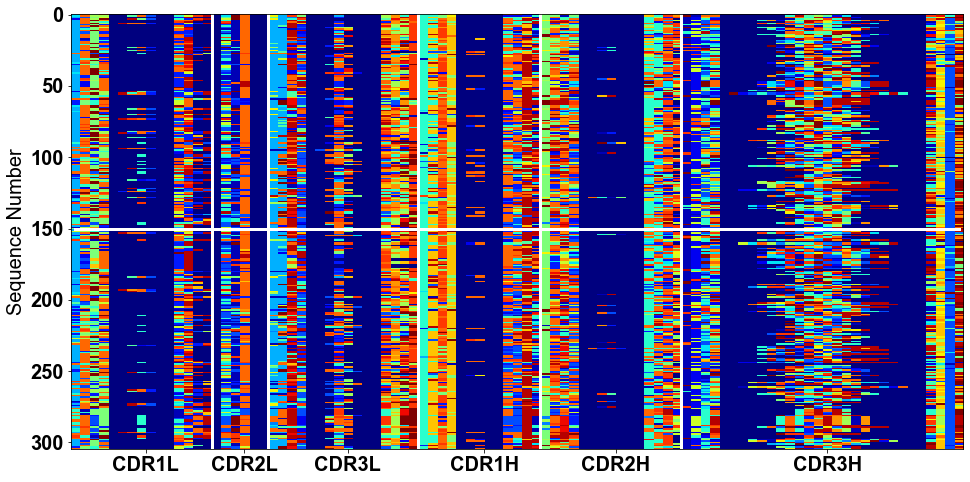

In [9]:
# ALIGNMENT OPTIONS are bulge, center, left, and right... pretty self explanatory besides bulge
# Bulge aligns the germline regions of CDR3 (and other loops) and then center aligns what is left
seq_MI1 = aims.gen_tcr_matrix(np.array(seq1),key = AA_num_key, giveSize = mat_size, alignment = 'bulge')
seq_MI2 = aims.gen_tcr_matrix(np.array(seq2),key = AA_num_key, giveSize = mat_size, alignment = 'bulge')
seq_MIp1 = pandas.DataFrame(np.transpose(seq_MI1),columns = seq1.columns)
seq_MIp2 = pandas.DataFrame(np.transpose(seq_MI2),columns = seq2.columns)
seq_MIf = pandas.concat([seq_MIp1,seq_MIp2],axis=1)
fig, ax = pl.subplots(1, 1,squeeze=False,figsize=(16,8))
ax[0,0].imshow(np.transpose(seq_MIf), interpolation='nearest', aspect='auto',cmap=cm.jet)
ax[0,0].set_ylabel('Sequence Number')

# Plot a single line delineating the distinct groups we are studying.
ax[0,0].plot(np.arange(len(seq_MIf)),np.ones(len(seq_MIf))*len(seq_MI1),'white',linewidth = 3)
######
# It will help to have vertical white lines to guide the viewer
Numclones = int(np.shape(seq1)[1] + np.shape(seq2)[1])
if type(mat_size) != int:
    for i in np.arange(len(mat_size)-1):
        ax[0,0].plot( (mat_size[i] + sum(mat_size[:i]) - 0.5) * np.ones(Numclones),np.arange(Numclones),'white',linewidth = 3)
#######

if num_loop == 1:
    ax[0,0].set_xlabel('Sequence Position')
elif num_loop == 2:
    ax[0,0].set_xticks(xtick_loc)
    ax[0,0].set_xticklabels(['CDR3L','CDR3H'])
elif num_loop == 6:
    ax[0,0].set_xticks(xtick_loc)
    ax[0,0].set_xticklabels(['CDR1L','CDR2L','CDR3L','CDR1H','CDR2H','CDR3H'])
# Can also edit the saved figure name and format, if you want
#pl.savefig('matrix_fig.pdf',format='pdf')

Text(0, 0.5, 'Normalized Property Value')

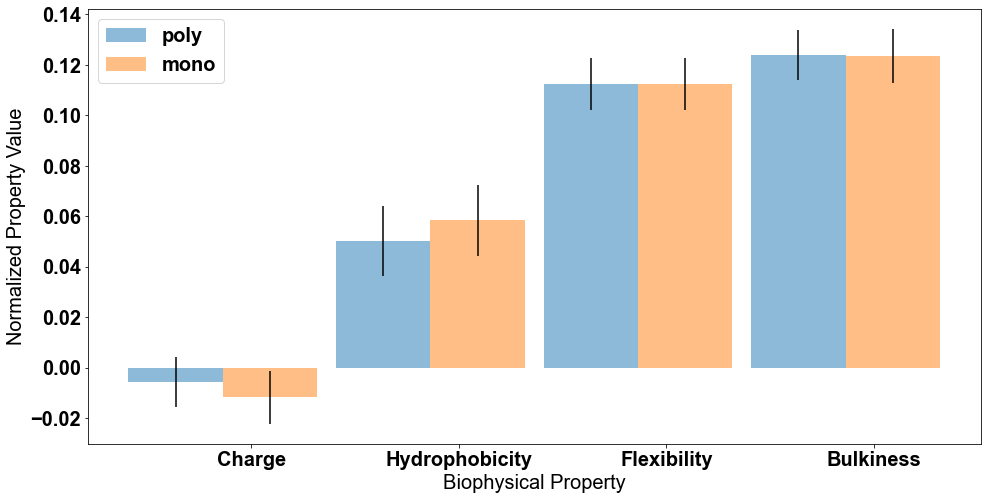

In [7]:
pca_props = aims.gen_clone_props(np.array(np.transpose(seq_MIf)))
pcaF = pandas.DataFrame(pca_props,columns = seq_MIf.columns)
fig, ax = pl.subplots(1, 1,squeeze=False,figsize=(16,8))
x_axis = np.array([-0.2,0.9,2,3.1])
# Need to have some kind of color wheel to replace this...
#colors = ['purple','green','black','orange']
for i in np.arange(len(label)):
    index = [column for column in pcaF.columns if label[i] in column]
    plotThis = np.array(pcaF[index])
    # Specifically plot the first 5 properties here... Make sure that I 
    # have some way soon to actually select these...
    ax[0,0].bar(x_axis+i*1/len(label), np.average(plotThis[1:5,:],axis = 1),
                yerr = np.std(plotThis[1:5,:],axis = 1),alpha = 0.5, width = 1/len(label))
ax[0,0].legend(label)
ax[0,0].set_xticks([0.2,1.3,2.4,3.5])
ax[0,0].set_xticklabels(['Charge','Hydrophobicity','Flexibility','Bulkiness'])
ax[0,0].set_xlabel('Biophysical Property')
ax[0,0].set_ylabel('Normalized Property Value')
#pl.savefig('property_fig.pdf',format='pdf')

[0.3398906  0.13163013 0.10423898]


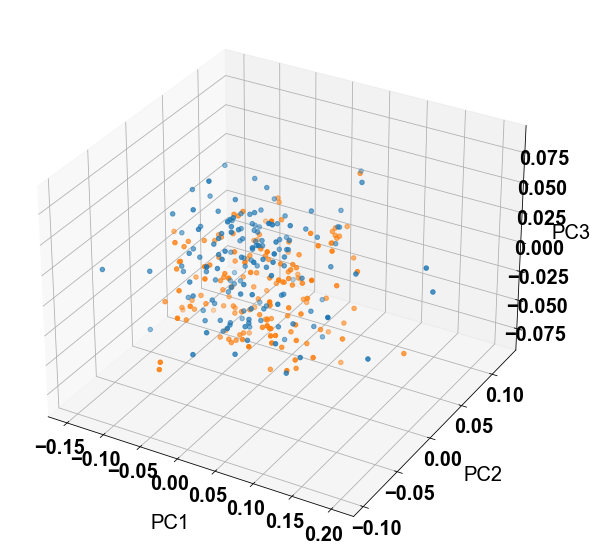

In [20]:
from sklearn.decomposition import PCA
full_seq = pandas.concat([seq1, seq2],axis =1 )
pca = PCA(n_components=3, svd_solver='full')
final=pca.fit_transform(np.transpose(pca_props))
#seq_PCA = aims.gen_tcr_matrix(np.array(seq_final),key = AA_num_key, giveSize = mat_size)
#final = pca.fit_transform(seq_PCA)
print(pca.explained_variance_ratio_)

from mpl_toolkits import mplot3d
fig3d = pl.figure(figsize = (10, 10))
ax3d = fig3d.add_subplot(111, projection='3d')

# Alright plot this in an intelligent way
transform_pca = pandas.DataFrame(np.transpose(final),columns = full_seq.columns)
for i in np.arange(len(label)):
    index = [column for column in transform_pca.columns if label[i] in column]
    plotThis = np.array(transform_pca[index])
    # Specifically plot the first 5 properties here... Make sure that I 
    # have some way soon to actually select these...
    ax3d.scatter(plotThis[0], plotThis[1], plotThis[2])

ax3d.set_xlabel('PC1',labelpad=20)
ax3d.set_ylabel('PC2',labelpad=20)
ax3d.set_zlabel('PC3',labelpad=10)
#pl.savefig('PCA_parsedata_3D.pdf',DPI=500,format='pdf')
pl.show()

Text(0, 0.5, 'PC2')

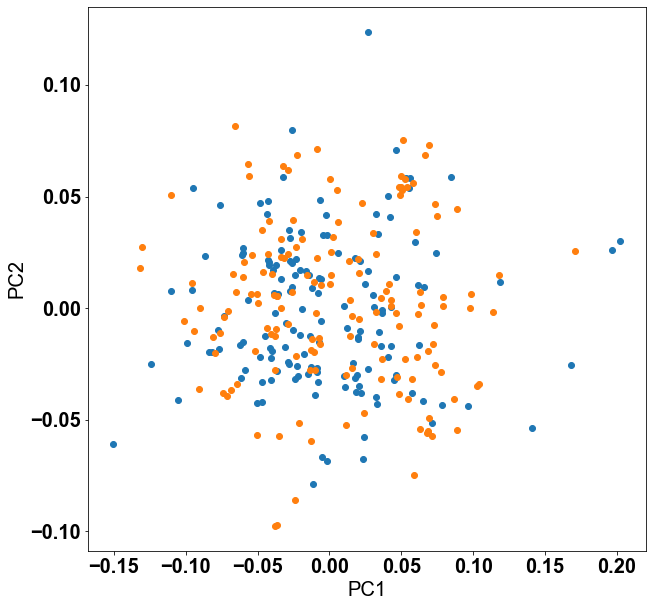

In [23]:
fig = pl.figure(figsize = (10, 10))
for i in np.arange(len(label)):
    #if i == 2:
    #    continue
    index = [column for column in transform_pca.columns if label[i] in column]
    plotThis = np.array(transform_pca[index])
    # Specifically plot the first 5 properties here... Make sure that I 
    # have some way soon to actually select these...
    pl.scatter(plotThis[0], plotThis[1])
    
pl.xlabel('PC1')
pl.ylabel('PC2')
#pl.savefig('PCA_2Dparse.pdf',DPI=500,format='pdf')

# Important Note About the Pos_Sens Plots
Due to EXCEPTIONAL conservation of amino acids at the edges of CDR3 in particular, it seems like some of the differences in other regions are fairly drowned out.... Unsure how to compensate for this. Keep in mind moving forward

(-1.0, 1.0)

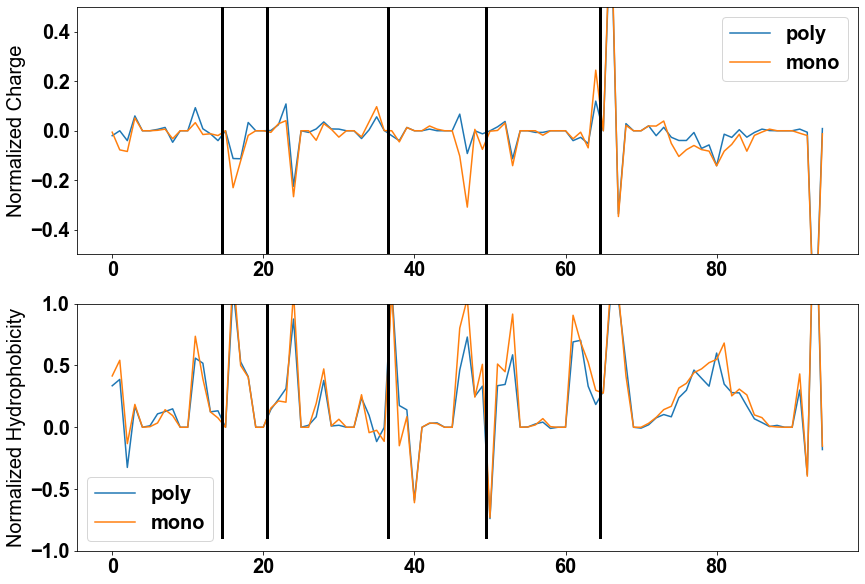

In [25]:
#pos_sens=aims.gen_dset_props(np.array(np.transpose(seq_MIf)),stdev=False)
fig, ax = pl.subplots(2, 1,squeeze=False,figsize=(14,10))
for i in np.arange(len(label)):
    index = [column for column in seq_MIf.columns if label[i] in column]
    subset = np.array(seq_MIf[index])
   
    pos_sens=aims.gen_dset_props(np.array(np.transpose(subset)),stdev=False)
    
    for prop in np.arange(2):
        if prop == 0:
            x = 0; y = 0
        elif prop == 1:
            x = 1; y = 0
#        elif prop == 2:
#            x = 1; y = 0
#        elif prop == 3:
#            x = 1; y = 1
        plotThis = pos_sens[prop+2]
        # Specifically plot the first 5 properties here... Make sure that I 
        # have some way soon to actually select these...
        ax[x,y].plot(np.arange(len(plotThis)), plotThis)
ax[0,0].legend(label)
ax[1,0].legend(label)

#ax[0,0].set_xticks(xtick_loc)
#ax[0,0].set_xticklabels(['CDR1L','CDR2L','CDR3L','CDR1H','CDR2H','CDR3H'])

#ax[1,0].set_xticks(xtick_loc)
#ax[1,0].set_xticklabels(['CDR1L','CDR2L','CDR3L','CDR1H','CDR2H','CDR3H'])

y11, y12 = ax[0,0].get_ylim()
y21, y22 = ax[1,0].get_ylim()
if type(mat_size) != int:
    for i in np.arange(len(mat_size)-1):
        ax[0,0].plot( (mat_size[i] + sum(mat_size[:i]) - 0.5) * np.ones(100),np.arange(y11,y12,(y12-y11)/100),'black',linewidth = 3)
        ax[1,0].plot( (mat_size[i] + sum(mat_size[:i]) - 0.5) * np.ones(100),np.arange(y21,y22,(y22-y21)/100),'black',linewidth = 3)

ax[0,0].set_ylabel('Normalized Charge')
ax[1,0].set_ylabel('Normalized Hydrophobicity')

# Want to look at these minute differences a little closer? Uncomment these
#ax[0,0].set_ylim([-0.5,0.5])
#ax[1,0].set_ylim([-1,1])

#pl.savefig('pos_sens_fig.pdf',format='pdf')

<AxesSubplot:xlabel='Dataset', ylabel='Linear Discriminant 1'>

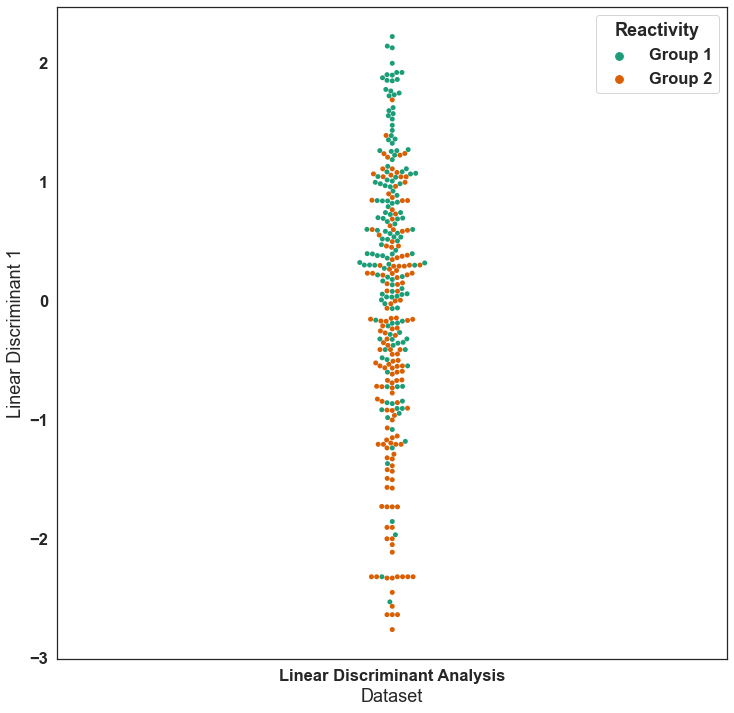

In [27]:
numVects = 10
# Here we also need to get a pre-defined matrix size...
import aims_classification as classy
pg1 = seq1.values
pg2 = seq2.values

num1 = np.shape(pg1)[1]
num2 = np.shape(pg2)[1]
#pg2 = seq2.values
x,y,MatrixSize = aims.gen_tcr_matrix(pg1,pre_mono=pg2,binary=True,return_Size=True,giveSize = mat_size)
acc_all,weights,cols,indices,mda_all, bigass = classy.do_linear_split(pg1, pg2, giveSize = MatrixSize, matSize = numVects, return_big = True)
# Seaborn plots look nicer for these LDA figures
import seaborn as sns
fig = pl.figure(figsize = (12, 12))
dset = ["Linear Discriminant Analysis" for x in range(num1+num2)]
reacts = ["Group 1" for x in range(num1)] + ["Group 2" for x in range(num2)]

d1 = {'Dataset': dset, 'Linear Discriminant 1': mda_all.reshape(len(mda_all)),
    'Reactivity' : reacts}
df1 = pandas.DataFrame(data=d1)
sns.set(style="white", color_codes=True,font_scale=1.5)
sns.swarmplot(x="Dataset", y="Linear Discriminant 1", data=df1, hue = 'Reactivity', palette = "Dark2")

#pl.savefig('lda_fig.pdf',format='pdf')

# New UMAP/High Dimensional Clustering Analysis
Make sure that you have already defined seq1 and seq2, which should be #Loops rows by #Clones columns of amino acid sequences.
Should work for an arbitrarily large number of "seq" files, but haven't tried yet.

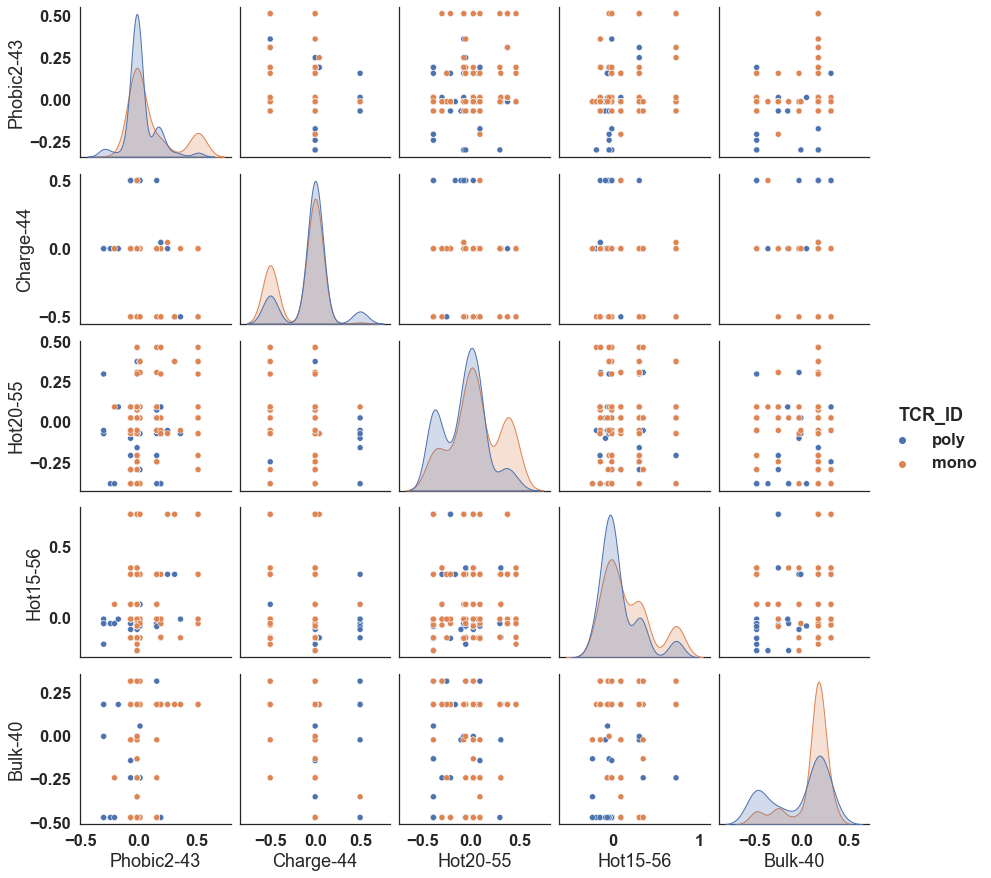

In [28]:
# show_top = how many of these top values do you want to show? don't recommend more than ~5
show_top = 5

col1 = [label[0] for a in np.arange(num1)]
col2 = [label[1] for a in np.arange(num2)]
col_names = col1+col2
dset_ID = pandas.DataFrame(col_names,columns = ['TCR_ID'])
dset_parseF = bigass[cols[indices[:show_top]]]
bigass_parse_dset = pandas.concat([dset_parseF,dset_ID],axis = 1)
sns.pairplot(bigass_parse_dset,hue = 'TCR_ID')

In [29]:
# Maybe we should try doing UMAP? Idk at least test it out.
import umap
# I guess I should Scale the data?
from sklearn.preprocessing import StandardScaler
reducer = umap.UMAP(n_components=2, n_neighbors = 50,min_dist=0.0)
# Perform UMAP on the inputs to LDA?
#chosen_dset = dset_parseF
# Or perform UMAP on the whole dataset?
#chosen_dset = bigass
# Or perform it on the dataset with correlated vectors removed?
chosen_dset = bigass[cols]

scaleData = StandardScaler().fit_transform(chosen_dset)

In [30]:
embedding = reducer.fit_transform(scaleData)
# Confirm that you're embedding based on the sequences, and don't need to transpose the data
embedding.shape

(305, 2)

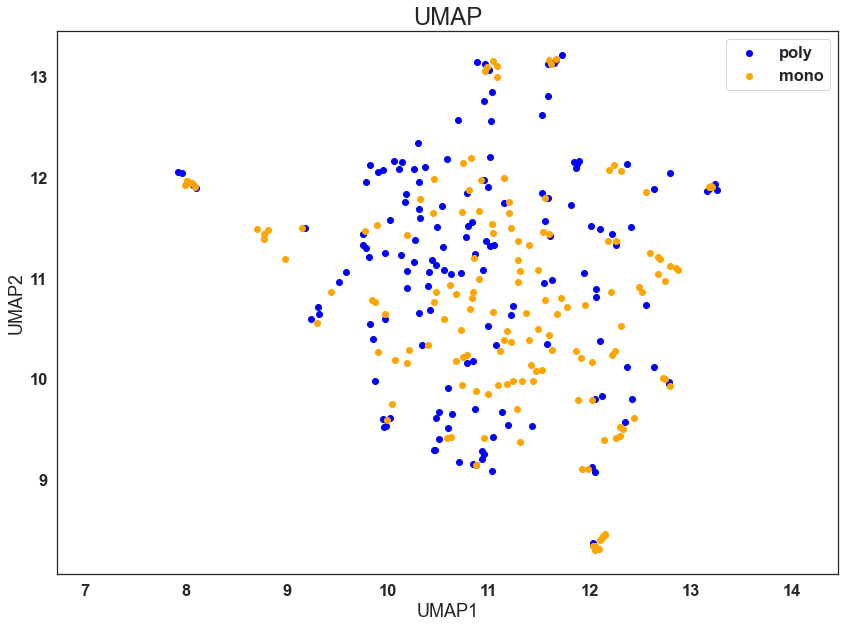

In [31]:
fig, ax = pl.subplots(1, 1,squeeze=False,figsize=(14,10))
pl.scatter(
    embedding[:num1, 0],
    embedding[:num1, 1],
    color='blue')
pl.scatter(
    embedding[num1:, 0],
    embedding[num1:, 1],
    color='orange')
pl.gca().set_aspect('equal', 'datalim')
pl.title('UMAP', fontsize=24)
pl.xlabel('UMAP1')
pl.ylabel('UMAP2')
pl.legend(label)

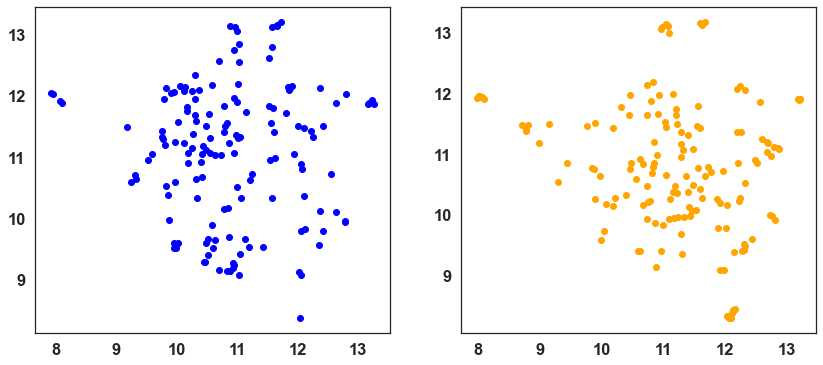

In [32]:
# Just to be sure of what you're seeing, plot the two UMAP plots side by side
fig, ax = pl.subplots(1, 2,squeeze=False,figsize=(14,6))
ax[0,0].scatter(
    embedding[:num1, 0],
    embedding[:num1, 1],
    color='blue')
ax[0,1].scatter(
    embedding[num1:, 0],
    embedding[num1:, 1],
    color='orange')
#pl.gca().set_aspect('equal', 'datalim')

# DONT FORGET, EVERY TIME YOU RE-RUN THE BELOW CELL YOU WILL GET A SLIGHTLY DIFFERENT RESULT
Or sometimes a massively different result, TBH

Text(0, 0.5, 'UMAP2')

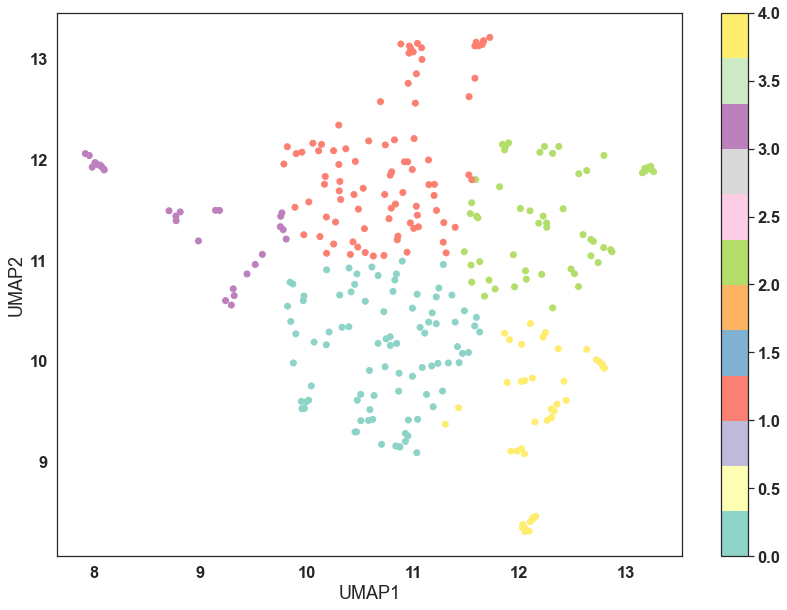

In [33]:
## Let's try to cluster these UMAP projections. IMPORTANT NOTES/CAVEATS FROM UMAP-LEARN GITHUB (also where code comes from):
#The most notable is that UMAP, like t-SNE, does not completely preserve density. 
#UMAP, like t-SNE, can also create false tears in clusters, resulting in a finer clustering than is necessarily present in the data. 
#Despite these concerns there are still valid reasons to use UMAP as a preprocessing step for clustering

import sklearn.cluster as cluster

fig, ax = pl.subplots(1, 1,squeeze=False,figsize=(14,10))
kmeans_labels = cluster.KMeans(n_clusters=5).fit_predict(embedding)
# Try to find better colormaps here: https://matplotlib.org/stable/tutorials/colors/colormaps.html
x = pl.scatter(embedding[:,0],embedding[:,1],c = kmeans_labels,cmap='Set3')
# Don't yet know a better way of having a legend aside from the cbar...
pl.colorbar(x)
pl.xlabel('UMAP1')
pl.ylabel('UMAP2')

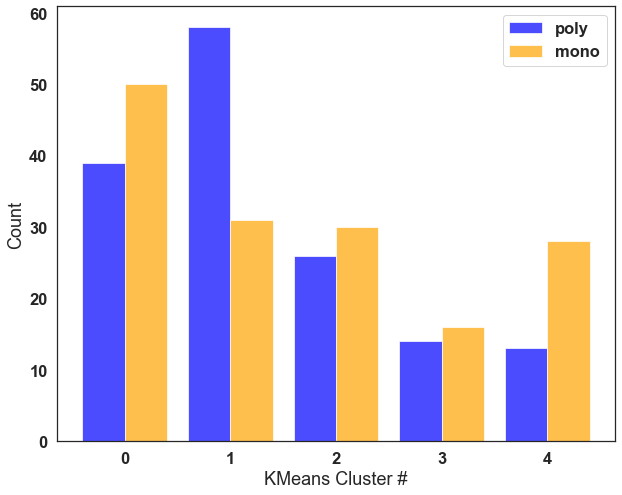

In [34]:
# Find representative entries from the clusters
fig, ax = pl.subplots(1, 1,squeeze=False,figsize=(10,8))
kmean_dset = pandas.DataFrame(kmeans_labels,columns=['kmean_cluster'])
kmean_breakdown = pandas.concat([chosen_dset,dset_ID, kmean_dset],axis=1)
# auto-identify number of clusters
n1 = 0; n2 = 0
for i in np.sort(kmean_breakdown['kmean_cluster'].drop_duplicates()):
    num = kmean_breakdown[kmean_breakdown['kmean_cluster'] == i]
    pl.bar(i-0.2,len(num[num['TCR_ID'] == label[0]]),color='blue',width=0.4,alpha = 0.7)
    pl.bar(i+0.2,len(num[num['TCR_ID'] == label[1]]),color='orange',width=0.4,alpha = 0.7)
pl.xlabel('KMeans Cluster #')
pl.ylabel('Count')
pl.legend(label)

In [35]:
# Now what if you want to go back and pick out some TCRs from these clusters?
clusterID = 1

sequences = np.transpose(np.hstack((seq1.values,seq2.values)))
tags = np.hstack((seq1.columns,seq2.columns))
iso_seqs = sequences[kmean_breakdown['kmean_cluster'] == clusterID]
iso_tags = tags[kmean_breakdown['kmean_cluster'] == clusterID]

# You can then, for instance, save these sequences from the KMeans data for meaningful analysis
# Or maybe tying back into V-gene usage, etc.
#pandas.DataFrame(iso_seqs).to_csv('cluster'+str(clusterID)+'_sequences.dat')
#pandas.DataFrame(iso_tags).to_csv('cluster'+str(clusterID)+'_IDs.dat')

In [36]:
# LEAVE THIS HERE AS A SEPARATE "THING TO LOOK INTO" Section
# import hbdscan
#lowd_dset = PCA(n_components=50).fit_transform(scaleData)
#hdbscan_labels = hdbscan.HDBSCAN(min_samples=10, min_cluster_size=500).fit_predict(lowd_mnist)
#where HDBSCAN [is] willing to cluster it [gets] things almost entirely correct. 
#This is what it was designed to do – be right for what it can, 
#and defer on anything that it couldn’t have sufficient confidence in.

# THIS IS A VERY INTERESTING WAY OF DOING THINGS... FIND OUR "MOST CONFIDENT" CLASSIFICATIONS!
# Note however, that this can result in clustering very limited subsets of the data...

In [37]:
indices_topProps = np.argsort(abs(weights))
compile_Props = np.vstack((cols[indices],weights))
final_pc1 = compile_Props[:,indices_topProps[0][-10:]]
print(final_pc1[0,0])
print(round(final_pc1[1,0]**2,4))

Bulk-55
0.0852


(95, 21)
(95, 21)


Text(0, 0.5, 'Shannon Entropy (Bits)')

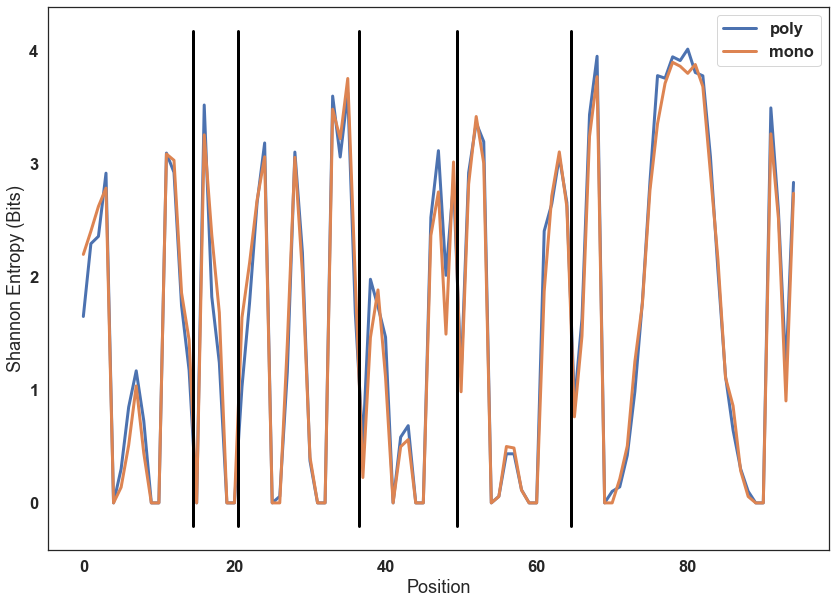

In [46]:
# There's no reason to not add the information theory stuff, even if it isn't in the app yet
fig, ax = pl.subplots(1, 1,squeeze=False,figsize=(14,10))
poses = len(seq_MIf)
frequencies = np.zeros((len(label),poses,21))
for i in np.arange(len(label)):
    index = [column for column in seq_MIf.columns if label[i] in column]
    subset = np.array(seq_MIf[index])
    entropy,AA_count=aims.calculate_shannon(np.transpose(subset))
    frequencies[i] = AA_count
    print(np.shape(AA_count))
    pl.plot(entropy, linewidth = 3)

# Guide the eyes with these lines
y11, y12 = ax[0,0].get_ylim()
if type(mat_size) != int:
    for i in np.arange(len(mat_size)-1):
        ax[0,0].plot( (mat_size[i] + sum(mat_size[:i]) - 0.5) * np.ones(100),np.arange(y11,y12,(y12-y11)/100),'black',linewidth = 3)
        
pl.legend(label)
pl.xlabel('Position')
pl.ylabel('Shannon Entropy (Bits)')
#pl.savefig('entropy_fig.pdf',format='pdf')

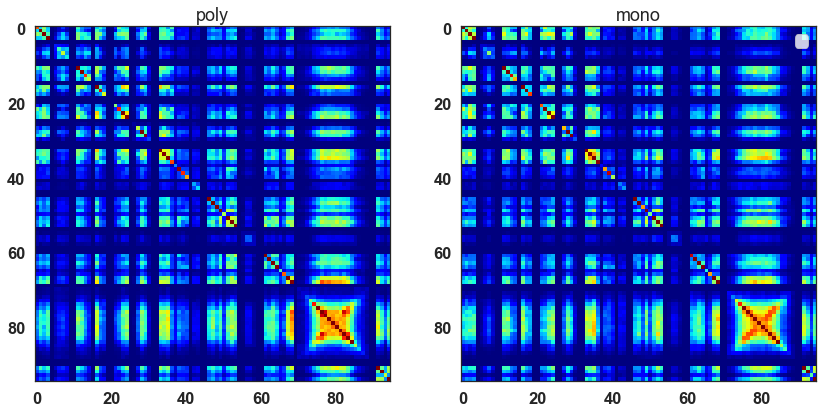

In [43]:
# And then the mutual information:
fig, ax = pl.subplots(1, 2,squeeze=False,figsize=(14,10))
poses = len(seq_MIf)
MI_master = np.zeros((len(label),poses,poses))
for i in np.arange(len(label)):
    index = [column for column in seq_MIf.columns if label[i] in column]
    subset = np.array(seq_MIf[index])
    MI,entropy_cond,counted=aims.calculate_MI(np.transpose(subset))
    MI_master[i] = MI
    ax[0,i].imshow(MI,vmin=0,vmax=2,cmap=cm.jet)
#pl.colorbar(x)
ax[0,0].set_title(label[0])
ax[0,1].set_title(label[1])
pl.legend(label)
#pl.savefig('MI_fig.pdf',format='pdf')

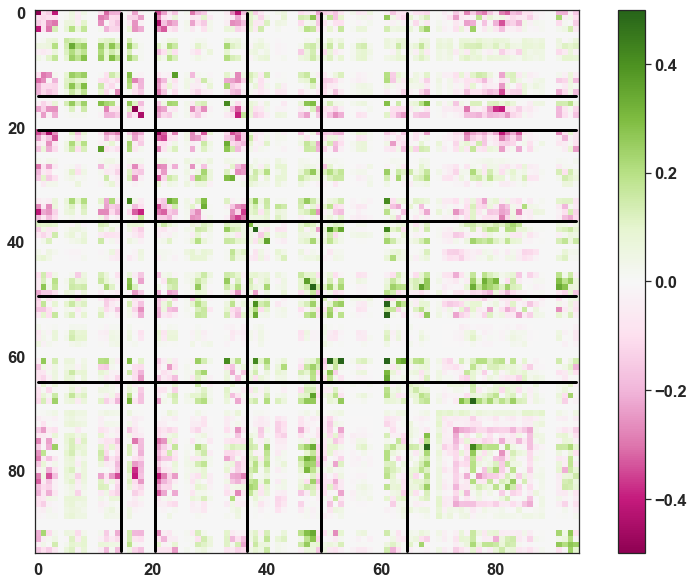

In [44]:
fig, ax = pl.subplots(1, 1,squeeze=False,figsize=(14,10))
x = pl.imshow(MI_master[0] - MI_master[1], cmap=cm.PiYG, vmin = -0.5, vmax = 0.5)

# Help Guide the eyes a bit
if type(mat_size) != int:
    for i in np.arange(len(mat_size)-1):
        ax[0,0].plot( (mat_size[i] + sum(mat_size[:i]) - 0.5) * np.ones(100),np.arange(0,poses,poses/100),'black',linewidth = 3)
        ax[0,0].plot( np.arange(0,poses,poses/100), (mat_size[i] + sum(mat_size[:i]) - 0.5) * np.ones(100) ,'black',linewidth = 3)

pl.colorbar(x)
#pl.savefig('bulgeAlign_51Y_MI2.pdf',format='pdf')

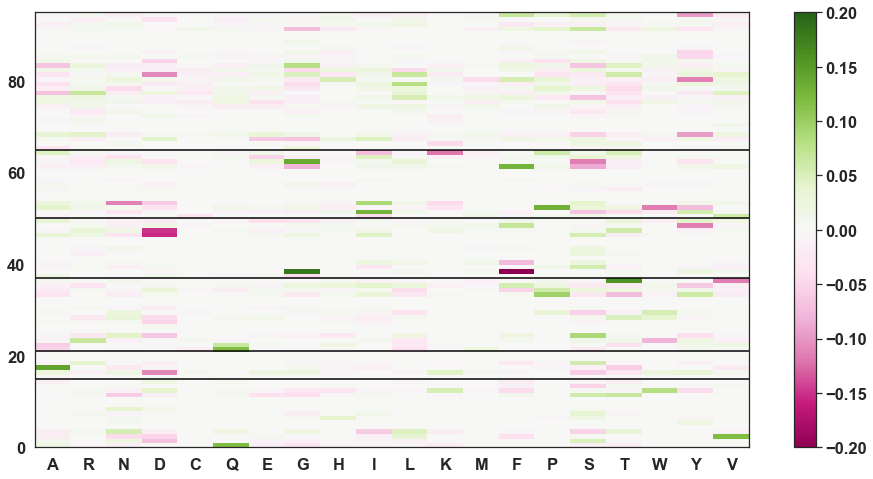

In [42]:
# Alright so the frequency data is actually calculated on the Shannon Entropy step
# Go back to that code to make sure we save it somehow, then just plot it here

fig, ax = pl.subplots(1, 1,squeeze=False,figsize=(16,8))
# We need to have the data in the binary groups though, since we're taking a difference.
# The 1: excludes "empty space" as a frequency
x=ax[0,0].pcolormesh(frequencies[0,:,1:]-frequencies[1,:,1:],vmin=-0.2,vmax=0.2,cmap=cm.PiYG)
AA_key=['A','R','N','D','C','Q','E','G','H','I','L','K','M','F','P','S','T','W','Y','V']
pl.colorbar(x)
xax=pl.setp(ax,xticks=np.arange(20)+0.5,xticklabels=AA_key)

place=0
for i in mat_size:
    place += i
    pl.plot(np.arange(21),place*np.ones(21),'black')

#pl.savefig('FULLdata_AAprob.eps', format='eps')# dpi=1000)

# Below is the Testing for the MHC version in the GUI

In [15]:
x1 = np.array(['cd1','HLA-A','UFA','UAA','UDA']); x2 = np.array(['124','170','22','2','2'])
x3 = np.array(['167','210','66','49','49']); x4 = np.array(['209','260','105','93','93'])
x5 = np.array(['262','306','158','152','152']);  x6 = np.array(['303','348','199','193','193'])
mat_coords = np.transpose(np.vstack((x1,x2,x3,x4,x5,x6)))
paths = ['app/mhc_testData/cd1_seqs.fasta',
'app/mhc_testData/hlaA_seqs.fasta',
'app/mhc_testData/cd1_ufa_genes.fasta',
'app/mhc_testData/UAA_seqs.fasta',
'app/mhc_testData/UDA_seqs.fasta']

In [95]:
# DEFINE PLOT PARAMETERS:
font = {'family' : 'Arial',
'weight' : 'bold',
'size'   : 16}
COLOR = 'black'
rcParams['text.color'] = 'black'
rcParams['axes.labelcolor'] = COLOR
rcParams['xtick.color'] = COLOR
rcParams['ytick.color'] = COLOR

rc('font', **font)

Text(0.5, 0, 'Sequence Position')

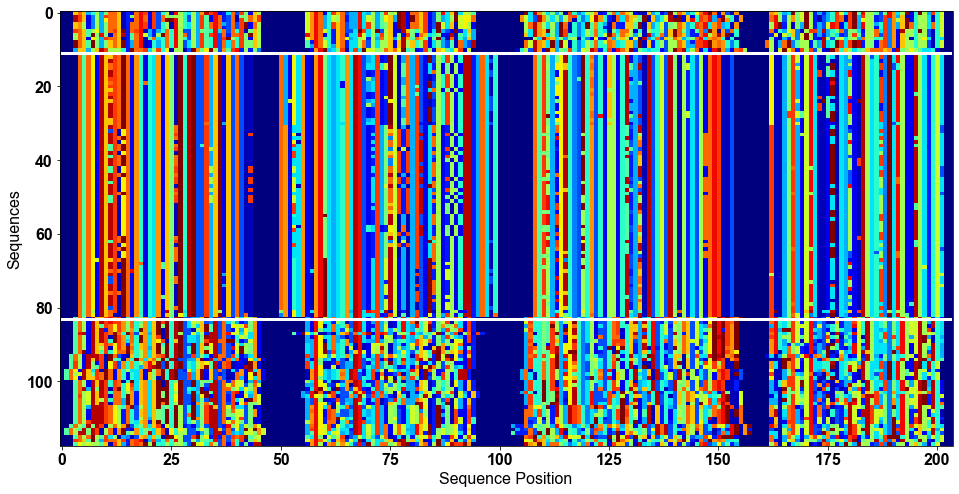

In [105]:
AA_num_key = aims.get_props()[1]
AA_num_key_new = aims.get_props()[2]
labels = mat_coords[:,0]
data = mat_coords[:,1:]
for i in np.arange(len(paths)):
    # turn data into an integer.
    int_dat = [int(x) for x in data[i]]
    seq,seq_key = aimsLoad.mhc_loader(paths[i],int_dat,labels[i])
    if i == 0:
        seq_final = seq
        seq_size = np.shape(seq)[1]
        seqNameF = labels[i]
        seq_keyF = seq_key
        mat_size = aims.get_sequence_dimension(np.array(seq))[0]
    else:
        seq_final = pandas.concat([seq_final,seq],axis = 1)
        seqNameF = np.vstack((seqNameF,labels[i]))
        seq_size = np.vstack((seq_size,np.shape(seq)[1]))
        seq_keyF = np.hstack((seq_keyF,seq_key))
        mat_size2 = aims.get_sequence_dimension(np.array(seq))[0]
        max_lenp=np.zeros(len(mat_size))
        for i in np.arange(len(mat_size)):
            max_lenp[i]=int(max(mat_size[i],mat_size2[i]))
        mat_size = max_lenp       
seq_MI = aims.gen_tcr_matrix(np.array(seq_final),key = AA_num_key, giveSize = mat_size)
# Convert our MI matrix to a pandas dataframe
seq_MIf = pandas.DataFrame(np.transpose(seq_MI),columns = seq_final.columns)
fig, ax = pl.subplots(1, 1,squeeze=False,figsize=(16,8))
ax[0,0].imshow(seq_MI, interpolation='nearest', aspect='auto',cmap=cm.jet)

seq_locs = 0
for i in np.arange(len(seq_size)-1):
    seq_locs = seq_locs + seq_size[i]
    ax[0,0].plot(np.arange(len(np.transpose(seq_MI))),np.ones(len(np.transpose(seq_MI)))*seq_locs,'white',linewidth = 3)

ax[0,0].set_ylabel('Sequences')
ax[0,0].set_xlabel('Sequence Position')
#fig.savefig('mhc_manuscript_Matrix.pdf',format='pdf',dpi=500)

Text(0, 0.5, 'Normalized Property Value')

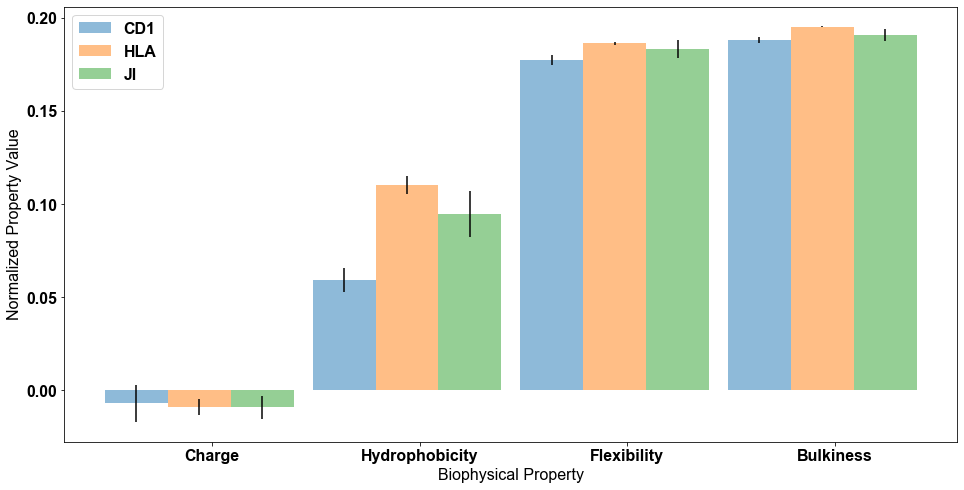

In [97]:
pca_props = aims.gen_clone_props(np.array(np.transpose(seq_MIf)))
pcaF = pandas.DataFrame(pca_props,columns = seq_MIf.columns)
fig, ax = pl.subplots(1, 1,squeeze=False,figsize=(16,8))
x_axis = np.array([-0.2,0.9,2,3.1])
# Need to have some kind of color wheel to replace this...
#colors = ['purple','green','black','orange']
for i in np.arange(len(seqNameF)):
    index = [column for column in pcaF.columns if seqNameF[i][0] in column]
    plotThis = np.array(pcaF[index])
    # Specifically plot the first 5 properties here... Make sure that I 
    # have some way soon to actually select these...
    ax[0,0].bar(x_axis+i*1/len(seqNameF), np.average(plotThis[1:5,:],axis = 1),
                yerr = np.std(plotThis[1:5,:],axis = 1),alpha = 0.5, width = 1/len(seqNameF))
ax[0,0].legend(labels)
ax[0,0].set_xticks([0.2,1.3,2.4,3.5])
ax[0,0].set_xticklabels(['Charge','Hydrophobicity','Flexibility','Bulkiness'])
ax[0,0].set_xlabel('Biophysical Property')
ax[0,0].set_ylabel('Normalized Property Value')
#fig.savefig('mhc_manuscript_properties.pdf',format='pdf',dpi=500)

[0.43839639 0.06058969 0.04302005]


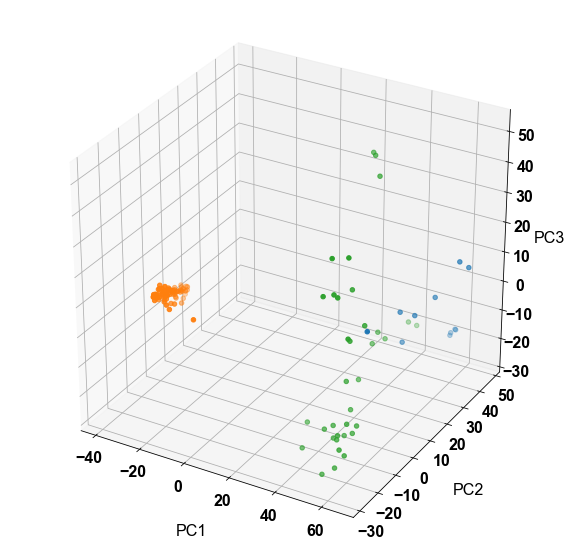

In [108]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3, svd_solver='full')
final=pca.fit_transform(np.transpose(pca_props))
#seq_PCA = aims.gen_tcr_matrix(np.array(seq_final),key = AA_num_key, giveSize = mat_size)
#final = pca.fit_transform(seq_PCA)
print(pca.explained_variance_ratio_)

from mpl_toolkits import mplot3d
fig3d = pl.figure(figsize = (10, 10))
ax3d = fig3d.add_subplot(111, projection='3d')

# Alright plot this in an intelligent way
transform_pca = pandas.DataFrame(np.transpose(final),columns = seq_MIf.columns)
for i in np.arange(len(seqNameF)):
    index = [column for column in transform_pca.columns if seqNameF[i][0] in column]
    plotThis = np.array(transform_pca[index])
    # Specifically plot the first 5 properties here... Make sure that I 
    # have some way soon to actually select these...
    ax3d.scatter(plotThis[0], plotThis[1], plotThis[2])

ax3d.set_xlabel('PC1',labelpad=20)
ax3d.set_ylabel('PC2',labelpad=20)
ax3d.set_zlabel('PC3',labelpad=10)
#pl.savefig('PCA_parsedata_3D.pdf',DPI=500,format='pdf')
pl.show()

Text(0, 0.5, 'PC2')

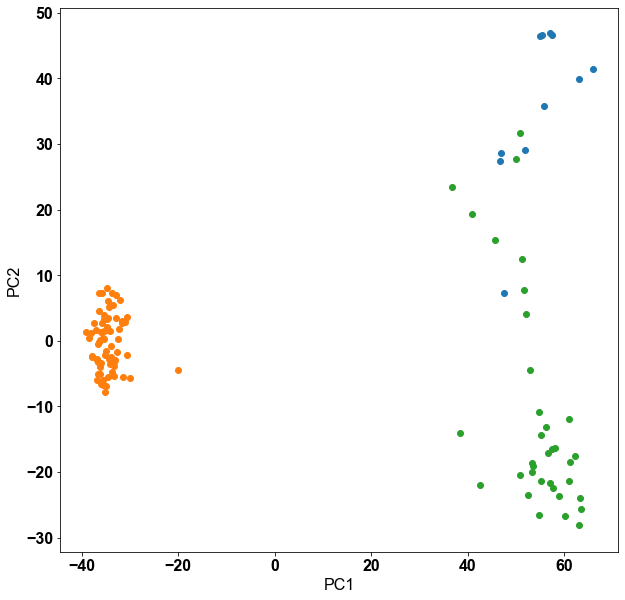

In [109]:
fig = pl.figure(figsize = (10, 10))
for i in np.arange(len(seqNameF)):
    #if i == 2:
    #    continue
    index = [column for column in transform_pca.columns if seqNameF[i][0] in column]
    plotThis = np.array(transform_pca[index])
    # Specifically plot the first 5 properties here... Make sure that I 
    # have some way soon to actually select these...
    pl.scatter(plotThis[0], plotThis[1])
    
pl.xlabel('PC1')
pl.ylabel('PC2')
#pl.savefig('PCA_2Dparse.pdf',DPI=500,format='pdf')

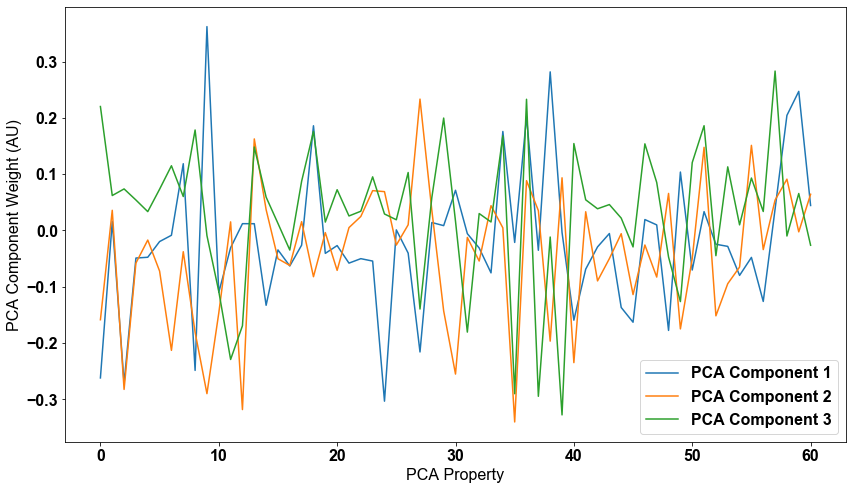

In [31]:
comps1=pca.components_[0]
comps2=pca.components_[1]
comps3=pca.components_[2]

fig, ax = pl.subplots(1, 1,squeeze=False,figsize=(14,8))
pl.plot(comps1)
pl.plot(comps2)
pl.plot(comps3)
pl.xlabel('PCA Property')
pl.ylabel('PCA Component Weight (AU)')
pl.legend(['PCA Component 1','PCA Component 2','PCA Component 3'])

Text(0, 0.5, 'Normalized Hydrophobicity')

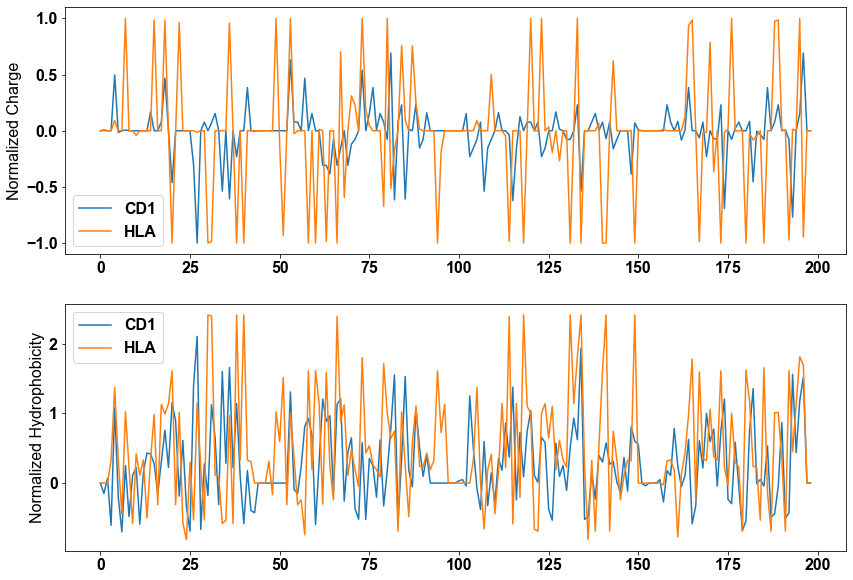

In [80]:
#pos_sens=aims.gen_dset_props(np.array(np.transpose(seq_MIf)),stdev=False)
fig, ax = pl.subplots(2, 1,squeeze=False,figsize=(14,10))
for i in np.arange(len(labels)):
    index = [column for column in seq_MIf.columns if labels[i] in column]
    subset = np.array(seq_MIf[index])
   
    pos_sens=aims.gen_dset_props(np.array(np.transpose(subset)),stdev=False)
    
    for prop in np.arange(2):
        if prop == 0:
            x = 0; y = 0
        elif prop == 1:
            x = 1; y = 0
#        elif prop == 2:
#            x = 1; y = 0
#        elif prop == 3:
#            x = 1; y = 1
        plotThis = pos_sens[prop+2]
        # Specifically plot the first 5 properties here... Make sure that I 
        # have some way soon to actually select these...
        ax[x,y].plot(np.arange(len(plotThis)), plotThis)
ax[0,0].legend(labels)
ax[1,0].legend(labels)

#ax[0,0].set_xticks(xtick_loc)
#ax[0,0].set_xticklabels(['CDR1L','CDR2L','CDR3L','CDR1H','CDR2H','CDR3H'])

#ax[1,0].set_xticks(xtick_loc)
#ax[1,0].set_xticklabels(['CDR1L','CDR2L','CDR3L','CDR1H','CDR2H','CDR3H'])

ax[0,0].set_ylabel('Normalized Charge')
ax[1,0].set_ylabel('Normalized Hydrophobicity')

1.0


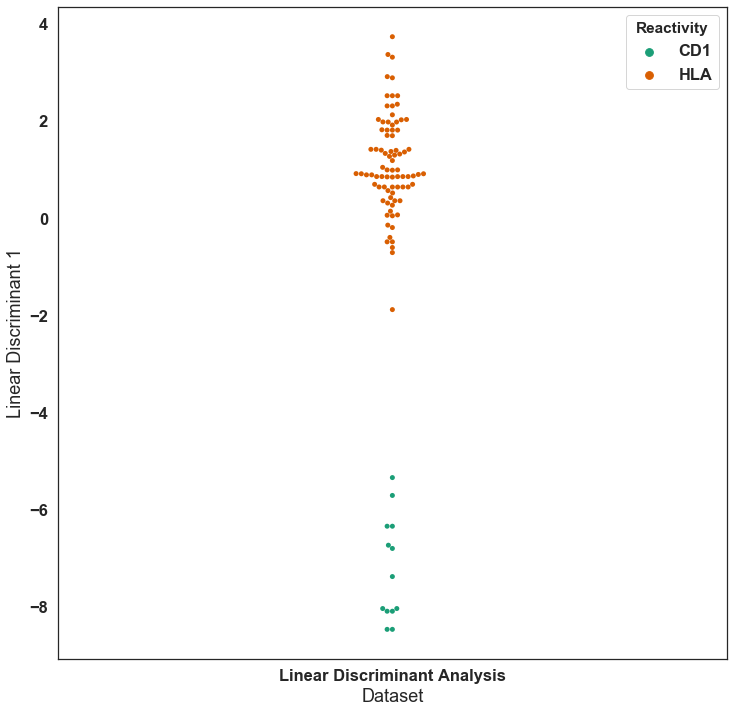

In [16]:
numVects = 10
# Here we also need to get a pre-defined matrix size...
import aims_classification as classy

# Need to split this data into two classes
# We (in the tutorials) have these labels:
#['cd1', 'HLA-A', 'UFA', 'UAA', 'UDA']
# So let's split these up into the below classes:
class_assign = [1,2,0,0,0]
# Here we have 1 = class 1, 2 = class 2, and we'll keep 0 as "unassigned"

class0 = []
class1 = []
class2 = []
for i in np.arange(len(labels)):
    index = [column for column in seq_final.columns if labels[i] in column]
    subset = seq_final[index]
   
    if class_assign[i] == 0:
        if len(class0) == 0:
            class0 = subset
        else:
            class0 = np.hstack((class0,subset))
    elif class_assign[i] == 1:
        if len(class1) == 0:
            class1 = subset
        else:
            class1 = np.hstack((class1,subset))
    elif class_assign[i] == 2:
        if len(class2) == 0:
            class2 = subset
        else:
            class2 = np.hstack((class2,subset))

pg1 = class1.values
pg2 = class2.values

num1 = np.shape(pg1)[1]
num2 = np.shape(pg2)[1]
#pg2 = seq2.values
x,y,MatrixSize = aims.gen_tcr_matrix(pg1,pre_mono=pg2,binary=True,return_Size=True)
acc_all,weights,cols,indices,mda_all,did_drop = classy.do_linear_split(pg1, pg2, giveSize = MatrixSize, ridCorr = True, matSize = numVects)
# Seaborn plots look nicer for these LDA figures
import seaborn as sns
fig = pl.figure(figsize = (12, 12))
dset = ["Linear Discriminant Analysis" for x in range(num1+num2)]
reacts = ["CD1" for x in range(num1)] + ["HLA" for x in range(num2)]

d1 = {'Dataset': dset, 'Linear Discriminant 1': mda_all.reshape(len(mda_all)),
    'Reactivity' : reacts}
df1 = pandas.DataFrame(data=d1)
print(acc_all)
sns.set(style="white", color_codes=True,font_scale=1.5)
sns.swarmplot(x="Dataset", y="Linear Discriminant 1", data=df1, hue = 'Reactivity', palette = "Dark2")

# So the Above Section DOES Work, but Unfortunately the LDA is Honing in on the Alignment Mismatches
This isn't an issue in the PCA, because it's unbiased. This is where that software to autodefine helices and strands would help a LOT